In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab1_implicit.ipynb")

# Coding Lab \#1 Part 2: implicit finite differences

```{grid} 2 2 2 2 
**implicit finite differences**
:::{figure} figures/AshesiETHLogo.png
:alt: figure of logos
:align: right
:width: 300px
:::
```

:::{admonition} How to use this notebook?
This notebook is made of text cells and code cells. The code cells have to be **executed** to see the result of the program. \
To execute a cell, simply select it and click on the "play" button \(&#9658;\) in the tool bar just above the notebook, or type `shift+enter`
It is important to execute the code cells in their order of appearance in the notebook.

**As a first step**: execute the OtterGrader code cell at the very top of this notebook. 

If you are running into any problems, try restarting the kernel and then see if the issue persists. 
:::

## Learning goals

After using this notebook, you should be able to:
* understand implicit finite differences and their numerical implementation using python.

## Problem statement

We are solving the same inital boundary value problem as we saw in lab1_explicit.ipynb, however, we will be making us of a different discretization, let's take a look:

Consider a bar that is mounted at $x=L$, i.e $u(L,t) = 0$, and initially at rest. Starting at time $t=0$, someone hits the free end of the bar at $x=0$ with a hammer, as shown below in [](#hammer). 

```{figure} figures/rod_hitting_hammer_2025.png
:name: hammer
:alt: figure hitting rod with hammer
:width: 400px
:align: center
```
This hitting leads to an imposed deformation, which we model as a displacement boundary condition as follows: 
$$ 	
u(0,t) = 
	\begin{cases}
	u_{max} \cdot \frac{1}{2} \cdot\left[1 - \cos(32\, \frac{c_1\,t}{L})\right] , & 0 \leq \frac{c_1\,t}{L} \leq \pi/16,\\
	0, & \text{else}.
	\end{cases}
    \label{Eq:BCs}
$$

We are aiming to simulate the longitudinal elastic waves propagating through this 1D bar which consists of two alloys, alloy 1 in the first section up $x = 0.6L$, and alloy 2 in the remaining length.
We know the wave speeds
$$ 	
c = 
	\begin{cases}
	c_1 = \sqrt{\frac{E_1}{ρ_1}} , & 0 \leq x \leq 0.6{L},\\
c_2 = \sqrt{\frac{E_2}{ρ_2}}  , & 0.6L < x \leq {L}
	\end{cases}
    \label{Eq:wave_speeds}
$$
with Young's moduli $E_1,E_2$ and densities $\rho_1,\rho_2$ for the two alloys, respectively. 

We showed in class that the displacement field $u(x, t)$ of a propagating 1D wave is governed by the wave equation
$$
\ddot{u} = c^2 u_{,xx} 
$$
Let us use a finite-difference (FD) scheme to simulate elastic stress waves as they travel through the bar and are reflected at the fixed end. To this end, we discretize the bar both in time and space by increments of, respectively, $\Delta t $ and $ \Delta x$ to solve for displacements $u (x_{j}, t^{\alpha})= u_{j}^{\alpha}$ at positions $x_{j}$ and time steps $t^{\alpha}$. 

Let us study the same wave propagation problem as described above; **but now we make use of an *implicit* finite difference scheme.** 
While the discretization of the time domain remains the same as before, we will represent the spatial derivative at time $t^\alpha$ by an average of the corresponding derivatives at time steps $t^{\alpha-1}$ and $t^{\alpha+1}$, i.e., we replace $u_{,xx}(x_j,t^\alpha)$ by 
$$
\frac{1}{2}\left[u_{,xx}(x_j,t^{\alpha-1})+u_{,xx}(x_j,t^{\alpha+1})\right]
$$ 
in the wave equation to arrive at
$$
	\ddot{u} = \frac{c^2}{2}\left[u_{,xx}(x_j,t^{\alpha-1})+u_{,xx}(x_j,t^{\alpha+1})\right],
$$
and we now apply **central-difference approximations both in space and in time** as before to this new PDE.

***
:::{admonition} implicit update rule

Let us derive the **update rule** for this new scheme and **formulate the system of equations** for $n$ grid points, considering the boundary conditions. 

Starting with the above approximate version of the wave equation and substituting the second-order central-difference approximations for the second derivatives in time and space, we obtain
$$
\frac{{u}_j^{\alpha-1}-2{u}_j^\alpha+{u}_j^{\alpha+1}}{\Delta t^2}=\frac{c^2}{2}\left[\frac{{u}_{j-1}^{\alpha-1}-2{u}_j^{\alpha-1}+{u}_{j+1}^{\alpha-1}}{\Delta {x}^2}+\frac{{u}_{j-1}^{\alpha+1}-2{u}_j^{\alpha+1}+{u}_{j+1}^{\alpha+1}}{\Delta {x}^2}\right]+ O(\Delta x^2,\Delta t^2).
$$

Moving all terms at the next timestep $t^{\alpha+1}$ to the left-hand side and using the abbreviation $r = (c\frac{\Delta t}{\Delta x}) ^{2}$ leads to

$$
u_{j}^{\alpha + 1} (1 + r) - \frac{r}{2} (u_{j+1}^{\alpha+1} + u_{j-1}^{\alpha+1} )= 2 u_{j}^{\alpha} - u_{j}^{\alpha-1} + \frac{r}{2} \left(  u_{j+1}^{\alpha-1} - 2u_{j}^{\alpha-1}  + u_{j-1}^{\alpha-1}   \right).
$$

This is an *implicit* scheme because we cannot explicitly solve directly for the next time step at each node (the solution for the next time step at any one node depends on the solution at the next time step at all the other nodes). Therefore, we must solve for the displacements $u$ at the next time step for all nodes at once. This involves solving a linear system of equations ($\boldsymbol{K}\boldsymbol{U}_{new} =\boldsymbol{F}$) at each time step. If there are $n$ nodes, then we can assemble the system of equations into matrix form as

$$
	\left[\begin{array}{ccccccc}
		1 & 0 & 0 & 0 & 0 & 0 & 0 \\
		-\frac{r}{2}& (1+r) & -\frac{r}{2} & 0 & 0 & 0 & 0 \\
		0 & -\frac{r}{2} & (1+r) & -\frac{r}{2} & 0 & 0 & 0 \\
		0 & 0 & \cdot & \cdot & \cdot & 0 & 0 \\
		0 & 0 & 0 & -\frac{r}{2} & (1+r)& -\frac{r}{2} & 0 \\
		0 & 0 & 0 & 0 & -\frac{r}{2}& (1+r) & -\frac{r}{2} \\
		0 & 0 & 0 & 0 & 0 & 0 & 1
	\end{array}\right]
	\left[\begin{array}{c}
		{u}_0^{\alpha+1} \\
		{u}_1^{\alpha+1} \\
		{u}_2^{\alpha+1} \\
		\cdot \\
		\cdot \\
		{u}_{n-2}^{\alpha+1} \\
		{u}_{n-1}^{\alpha+1}
	\end{array}\right]
	=\boldsymbol{F}
$$

where the right-hand-side is given by

$$
	\boldsymbol{F}=
	\left[\begin{array}{c}
		\hat{u}({t}) \\
		2 u_{1}^{\alpha} - u_{1}^{\alpha-1} + \frac{r}{2} \left(  u_{2}^{\alpha-1} - 2u_{1}^{\alpha-1}  + u_{0}^{\alpha-1}   \right) \\ 
		\cdot \\
		2 u_{j}^{\alpha} - u_{j}^{\alpha-1} + \frac{r}{2} \left(  u_{j+1}^{\alpha-1} - 2u_{j}^{\alpha-1}  + u_{j-1}^{\alpha-1}   \right) \\
		\cdot \\
		2 u_{n-1}^{\alpha} - u_{n-1}^{\alpha-1} + \frac{r}{2} \left(  u_{n}^{\alpha-1} - 2u_{n-1}^{\alpha-1}  + u_{n-2}^{\alpha-1}   \right) \\
		0
	\end{array}\right].
$$

Note that we implemented the two Dirichlet (essential) boundary conditions at both ends of the bar by modifying the first and last row in the above system of equations, as discussed in class.

:::

***
### problem 1 a)
:::{admonition} submission requirement
:class: tip
Your task consists of writing a Python code that simulates the wave propagation in the bar and interpreting the results.

Implement the implicit scheme numerically in Python using the provided skeleton code.
Assume that in the boundary conditions
\begin{equation}
	L = 1\ \text{m}, \qquad
	c_1 = 6320  \ \text{m/s}, \qquad
    c_2 = 3240 \ \text{m/s}, \qquad
	u_{max} = 0.8 \cdot10^{-3} \ \text{m}.
\end{equation}

Simulate the wave motion up to the maximum time $$
t_{ \text{max} } = 2L/c_1\ \, \text{s}, $$ 
using increments of 
\begin{equation} 
\Delta x= L / (n-1) \text{ m} \qquad \text{and} \qquad \Delta t = 10^{-7} \text{ s},
\end{equation}
where $n$ represents the number of *nodes* along your bar. Use $n=101$ nodes.  



Use the provided plotting functions to visualize your results at the ten times $t = t_{ \text{max} } \cdot i/10$ with $i=1,\ldots,10$.

:::

## coding

:::{admonition} Let us start by refreshing our Python knowledge. (click on this box!)
:class: dropdown

  We will be making use of the numpy library for mathematical operations and treating arrays. 
  We import it
   ```python
  import numpy as np
  ```
  Whenever we want to use the functionality of numpy, we call it by using np.
  Some useful examples include initializing a vector of *size* filled with zeros and a matrix of *size x size*: 
  ```python
  vectorA = np.zeros(size)
  matrixA = np.zeros((size, size))
  ```
  We can also initialize the identity matrix of *size x size* by initializing 
```python
  matrixB = np.eye(size)
```

  Accessing the entries of an 2D array works as follows, when we call ```matrixA[0,0]``` we call the the very first entry in the array. If we want to access the position in the $i$th row and $j$th column, we simply call ```matrixA[i,j]```. 
If we would like to access all rows in column 2 for example it would look like this ```matrixA[:,2]```.  
  
Numpy also has a great set of linear algebra functions ready for us to use. For example, if we want to solve 
$$
\boldsymbol{b} = \boldsymbol{A}^{-1}\boldsymbol{c} 
$$
we can use the numpy package 
  ```python
   b = np.linalg.solve(A, c)
  ```

:::

First, we need to import some useful Python libraries.

**Execute the code cell below** so that the necessary libraries are imported.

In [2]:
# add the library folder to the path
import sys; sys.path.append('./lib')
# we'll need numpy for some mathematical operations (e.g. cos/sin functions) and treating arrrays
import numpy as np
# to compute square roots, etc. we require the math module
import math
# and we have our own plotting function, which does most of the work for us
from plotting_functions import plot_results
# display a message once all libraries are imported
print("Libraries imported.")

Libraries imported.


Next, we define the constants and discretization required for the numerical implementation. Most of this information can be copied from lab1_explicit.ipynb, fill out the missing information below:

:::{admonition} Warning
:class: warning

Be sure to have inputs set to the required values for your submission!

:::

In [23]:
# ========================
# define input parameters:
# ========================
u_max = 0.8E-3            # amplitude of boundary condition applied [m]
L = 1                 # length of the bar in [m]
n = 101                # number of nodes along the length of the bar. [-]
delta_x = L/(n-1)          # delta x as we need this later [m]
x_positions = np.linspace(0, L, n) # given, position vector containing all j gridpoints

c_1  = 6320               # wave speed [m/s]
c_2  = 3240               # wave speed [m/s]
c = np.zeros(n)       # given, empty vector to store wavespeeds per gridpoint
for j in range(0,n):  # given, let's fill c up
    if x_positions[j]<= 0.6*L:
        c[j] = c_1
    else:
        c[j] = c_2


delta_t = 1E-7   # time step size
t_max = 2 * L / c_1   # given, max simulation time [s]  

In [24]:
grader.check("initialize variables")

initialize variables results: All test cases passed!
initialize variables - 3 message: it seems like some of the constants are defined correctly


As the $\boldsymbol{K}$-matrix is constant in for our problem, it makes sense to create it before we enter our time loop. Therefore  let us create the $\boldsymbol{K}$-matrix required to solve the system of equations here too: 

In [25]:
# let's build the K-Matrix once and for all so that we can solve the system of equations K U_new = F:
K = np.eye(n)

for i in range(n-2):
    if x_positions[i]<=0.6*L:
        r = (c_1*delta_t/delta_x)**2
    else:
        r = (c_2*delta_t/delta_x)**2
    
    K[i+1][i:i+3] = [-r/2, (1+r), -r/2]

In [26]:
grader.check("assemble K matrix correctly")

assemble K matrix correctly results: All test cases passed!
assemble K matrix correctly - 1 message: it seems like you have taken care of the boundary conditions correctly. (beware, this does not check the full matrix!)

In [18]:
K

array([[ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-4.97284877, 10.94569754, -4.97284877, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -4.97284877, 10.94569754, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  3.6139129 ,
        -1.30695645,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -1.30695645,
         3.6139129 , -1.30695645],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ]])

let's print some information to screen (given):

In [27]:
print("======================")
print("simulation start")
print("======================")
message = f"delta_x = {delta_x} and delta_t = {delta_t}"
print(message)
print(f"c_1*delta_t / delta_x = {c_1 * delta_t / delta_x}")
print(f"c_2*delta_t / delta_x = {c_2 * delta_t / delta_x}")
print("======================")

simulation start
delta_x = 0.01 and delta_t = 1e-07
c_1*delta_t / delta_x = 0.06319999999999999
c_2*delta_t / delta_x = 0.0324


let's iterate over all time steps and solve for the displacement along the bar:

In [28]:
structDisp = []           # given, no changes required! a list for saving results for plotting purposes 
# Initialize vectors
U = np.zeros(n)         # U @ talpha
U_old = np.zeros(n)     # U @ talpha-1
U_new = np.zeros(n)     # U @ talpha + 1
# let's ininialize F as well, full of zeros for now: 
F = np.zeros(n)

# loop over all time steps, given
for t in np.arange(0, t_max + delta_t, delta_t):
    
    # write your code here
    U_new = np.zeros(n)

    F[1:-1] = 2*U[1:-1]-U_old[1:-1]+ ((c[1:-1]*delta_t/delta_x)**2)/2* \
                                (U_old[2:]-2*U_old[1:-1]+U_old[:-2])
    
    
    
    F[-1] = 0 
    if (c_1*t/L<=np.pi/16):
        F[0] = u_max/2*(1-np.cos(32*c_1*t/L))
    else:
        F[0] = 0

    U_new = np.linalg.solve(K,F)
    U_old = U.copy()
    U = U_new.copy()
    
    # Let's save results for plotting later on (no changes required, just keep this piece of code):
    if t / t_max >= len(structDisp) / 10:
        print(f"Saving results for t = {t / t_max:.{2}f} * t_max")
        structDisp.append({"displacements": U_new.copy()})
print(F)
print("simulation end")
print("======================")

Saving results for t = 0.00 * t_max
Saving results for t = 0.10 * t_max
Saving results for t = 0.20 * t_max
Saving results for t = 0.30 * t_max
Saving results for t = 0.40 * t_max
Saving results for t = 0.50 * t_max
Saving results for t = 0.60 * t_max
Saving results for t = 0.70 * t_max
Saving results for t = 0.80 * t_max
Saving results for t = 0.90 * t_max
Saving results for t = 1.00 * t_max
[ 0.00000000e+00 -5.57905128e-08 -3.95738033e-07  1.12516724e-07
  6.99772113e-07 -3.35233879e-07 -9.76874041e-07  7.24270011e-07
  1.39384627e-06 -1.01412754e-06 -1.92286587e-06  7.08714187e-07
  2.32762934e-06  2.66701366e-07 -1.99389524e-06 -1.64527869e-06
  9.51583586e-07  2.18327052e-06  6.62641422e-07 -1.36702155e-06
 -1.53905792e-06 -1.06981934e-06  1.23062715e-06  3.39487145e-06
  5.71060618e-07 -3.93800083e-06 -2.67827559e-06  1.72394582e-06
  3.51617088e-06  2.17672797e-06 -2.47736463e-06 -4.42348057e-06
 -2.64483416e-07  3.29473616e-06  2.23144351e-06  2.96330444e-07
 -1.91397679e-06 -2

In [29]:
grader.check("update and apply bcs")

update and apply bcs results: All test cases passed!
update and apply bcs - 1 message: nice, you initialized U to the correct size!

finally, plot the wave moving through the bar, the plotting is provided for you, simply run the code cell below:

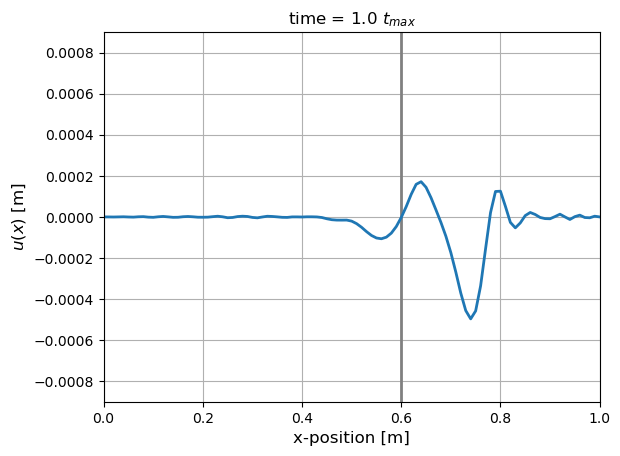

In [30]:
# Call the plotting function
plot_results(structDisp,L)

<!-- BEGIN QUESTION -->

***
### problem 1 b)

:::{admonition} submission requirement
:class: tip
What observation do you make regarding the **stability** of the scheme? What happens when you increase the number of grid points $n$ to $n = 1001$ as we did in lab1_explicit.ipynb? What can you say about the **runtime comparison** between the implicit and explicit codes **using the same parameters**?
And what happens if you use a larger time step $\Delta t$? Are the results you see above as you expected? How do these **results compare to the explicit scheme**? **Explain** the observations you make below. 

*Note*: You do not have to perform any calculations to answer this question, just state and explain your observations.
:::



- For the implicit scheme, the plot appear stable as the plot is bounded between the plot range.
- After increasing the n value to 1001, the plot appear more smoother and more closer to that of the Explicit scheme, which show higher accuracy unlike the case of n = 101
- For the same n value, I observed that the implicit scheme runtime is more than the explicit scheme runtime.
- After using a larger time step, the result obtained is as expected, implicit scheme result is stable and this is in agreement with the plot, as it remained bounded within the predefined plot range, however, the plot does not appear smooth, indicating less accuracy. This result is different from that of the explicit scheme which exploded for a larger time step value.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

***

## Closing remarks

When you reach this part of the script, your code should be running just fine. 
Further, you have taken some time to interpret some of the results. 


To close off this assignment on implicit finite differences, write down three points of what you have learned during this project in the provided space below. As a final point, you can also give an indication of how long it took you to complete this assignment. 

_Type your answer here, replacing this text._

<!-- END QUESTION -->

:::{admonition} important
:class: attention

Make sure that **execute** the entire notebook with the values of $\Delta t$ and $n$ as asked for in problem 1b) (!), then **save** it under the name **lab1_implicit.ipynb**. 

Once you finished both **lab1_explicit.ipynb** and **lab1_implicit.ipynb**, go back to **Moodle to submit** your assignment. Submit your lab1 folder with all its dependencies. 

Make sure that your two notebooks are indeed called exactly **lab1_explicit.ipynb** and **lab1_implicit.ipynb**.

Best of luck! 
:::